In [39]:
# Imports
import warnings
warnings.filterwarnings('ignore')
from io import BytesIO
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
np.random.seed(0) # Reproducibility

## Exercise 1

- Load the two time series `stationarity_ts1` and `stationarity_ts2` by running the code below.
1. Plot the two time series with a run sequence plot.
4. Based on the plot, discuss if each time series seems to be stationary or not.

In [40]:
# Load the first time series
response = requests.get("https://zenodo.org/records/10897398/files/stationarity_ts1.npy?download=1")
response.raise_for_status()
stationarity_ts1 = np.load(BytesIO(response.content))
print(len(stationarity_ts1))

# Load the second time series
response = requests.get("https://zenodo.org/records/10897398/files/stationarity_ts2.npy?download=1")
response.raise_for_status()
stationarity_ts2 = np.load(BytesIO(response.content))
print(len(stationarity_ts2))

time = np.arange(len(stationarity_ts1))
def run_sequence_plot(x, y, title, xlabel="Time", ylabel="Values", ax=None):
    if ax is None:
        _, ax = plt.subplots(1,1, figsize=(10, 3.5))
    ax.plot(x, y, 'k-')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(alpha=0.3)
    return ax

100
100


<Axes: title={'center': 'TS1'}, xlabel='Time', ylabel='Values'>

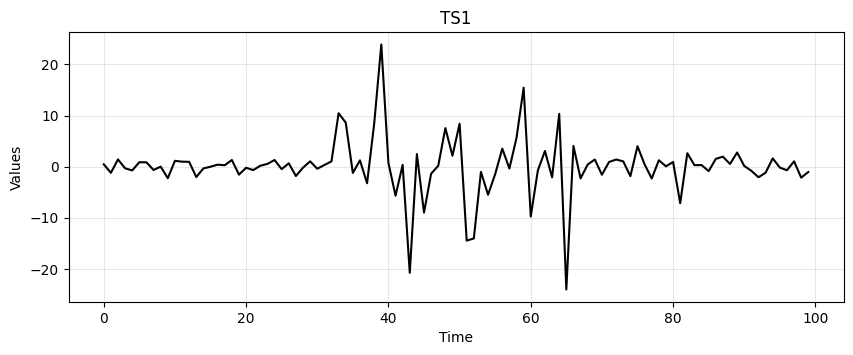

In [41]:
run_sequence_plot(time, stationarity_ts1, title="TS1")

The time series TS1 is probablt not stationary. The variance in the middle part is higher, the process is heteroskedastic

<Axes: title={'center': 'TS2'}, xlabel='Time', ylabel='Values'>

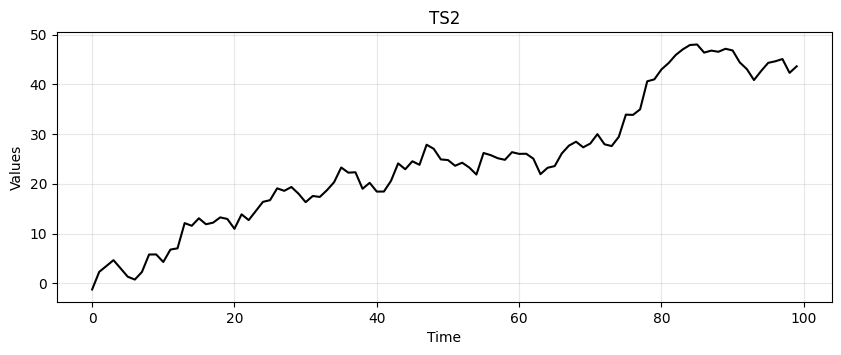

In [42]:
run_sequence_plot(time, stationarity_ts2, title="TS2")

The time series TS2 is not stationary. This is because the mean changes over times. 

(this makes also the variance unbounded, but the time variant mean is alone enaugh to reject stationarity)

## Exercise 2

Use the following tools to determine if the time series `stationarity_ts1` and `stationarity_ts2` are stationary or not.

1. Summary statistics on the chunks.
2. Augmented Dickey-Fuller test.

Discuss the result obtained with each method.

In [43]:
chunks_ts1 = np.split(stationarity_ts1, indices_or_sections=10)
print("---------- CHUNK ANLYSIS FOR TS1 ---------- \n")
print("{}\t | {}\t\t | {}".format("Chunk", "Mean", "Variance"))
print("-" * 35)
for i, chunks_ts1 in enumerate(chunks_ts1, 1):
    print("{:2}\t | {:.5}\t | {:.5}".format(i, np.mean(chunks_ts1), np.var(chunks_ts1)))

chunks_ts2 = np.split(stationarity_ts2, indices_or_sections=10)
print("\n\n---------- CHUNK ANLYSIS FOR TS2 ---------- \n")
print("{}\t | {}\t\t | {}".format("Chunk", "Mean", "Variance"))
print("-" * 35)
for i, chunks_ts2 in enumerate(chunks_ts2, 1):
    print("{:2}\t | {:.5}\t | {:.5}".format(i, np.mean(chunks_ts2), np.var(chunks_ts2)))

---------- CHUNK ANLYSIS FOR TS1 ---------- 

Chunk	 | Mean		 | Variance
-----------------------------------
 1	 | -0.14368	 | 1.1065
 2	 | 0.12109	 | 1.1652
 3	 | 0.047148	 | 0.76635
 4	 | 4.9208	 | 59.92
 5	 | -2.3263	 | 55.947
 6	 | -0.37065	 | 79.168
 7	 | -1.9508	 | 77.816
 8	 | 0.34635	 | 3.1884
 9	 | 0.30483	 | 7.293
10	 | -0.51908	 | 1.3469


---------- CHUNK ANLYSIS FOR TS2 ---------- 

Chunk	 | Mean		 | Variance
-----------------------------------
 1	 | 2.8186	 | 4.5026
 2	 | 10.511	 | 9.3034
 3	 | 16.023	 | 7.5191
 4	 | 19.733	 | 4.9789
 5	 | 23.268	 | 9.4271
 6	 | 24.608	 | 1.7717
 7	 | 25.543	 | 3.9608
 8	 | 32.736	 | 22.713
 9	 | 46.289	 | 2.2247
10	 | 43.773	 | 2.4782


The chunk analisys confirms the hypothesys made before.
- TS1 has higher variance in the middle chunks, making it heteroskedastic
- TS2 has infinite growing mean. Its mean is indeed not constant in time and its variance is unbounded.

Let's apply the Dickey-Fuller test

In [44]:
adf, pvalue_ts1, _, _, _, _  = adfuller(stationarity_ts1)
adf, pvalue_ts2, _, _, _, _  = adfuller(stationarity_ts2)
print(f"TS1: p-value: {pvalue_ts1}")
print(f"TS2: p-value: {pvalue_ts2}")

TS1: p-value: 0.03197606455861612
TS2: p-value: 0.6189258221979334


- TS2 cannot reject the null hypothesys, his p value is $61\%$. The itme series is heavly non stationary.
- TS1 rejects the null hypothesys within a confidence bound $<5\%$.

## Exercise 3
If either or both datasets from exercises one and two are nonstationary, apply the transformations you learned in this section to make them so. Then apply the methods you learned to ensure stationarity.

### TS1
With respect to the heteroscedasticit example in class, in this case the p value is halfed. 

This could be because the time series is split in $2/3$ + $1/3$ pieces with different variance, while in class the pslit was $1/2$ + $1/2$.

Lets apply the log transformation to squeeze the variance and see if how the test changes

p-value: 0.000


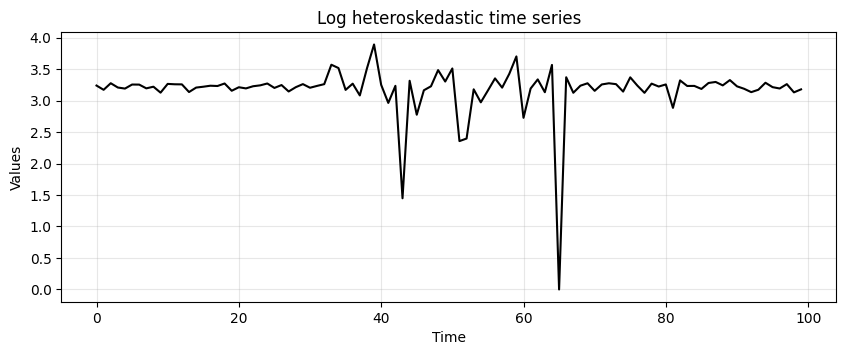

In [45]:
# Ensure all data are positive
positive_ts1 = stationarity_ts1 - stationarity_ts1.min() + 1

# Apply the log
log_ts1 = np.log(positive_ts1)
run_sequence_plot(time, log_ts1, title="Log heteroskedastic time series");

adf_log, pvalue_log, _, _, _, _ = adfuller(log_ts1)
print(f"p-value: {pvalue_log:.3f}")

We made the p value = 0, the new time series is stationary.

### TS2

TS2 has a constant trend + a residual component. Let's first remove the trend and see if the nre TS is stationary

p-value: 0.120


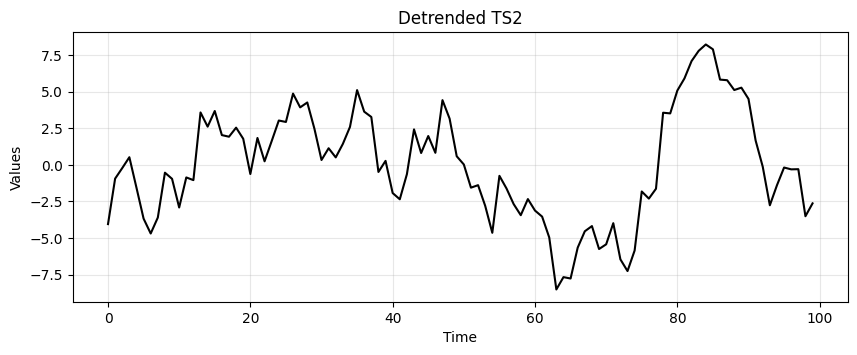

In [46]:
slope, intercept = np.polyfit(np.arange(len(stationarity_ts2)), stationarity_ts2, 1) # estimate line coefficient
trend_ts2 = np.arange(len(stationarity_ts2)) * slope + intercept # linear trend

detrended_ts2 = stationarity_ts2 - trend_ts2
run_sequence_plot(time, detrended_ts2, title="Detrended TS2");

adf_log, pvalue_dts2, _, _, _, _ = adfuller(detrended_ts2)
print(f"p-value: {pvalue_dts2:.3f}")

The time series is not yet stationary. 
- After removing the trend, the sequence plot does not show a clear seasonality.
- It shows instead a strong autocorrelation bteween neighbouring samples. Alse the variance increases a bit over time.
- Lets run again the chunk statistics to see if the variance is increasing.

In [47]:
chunks_dts2 = np.split(detrended_ts2, indices_or_sections=10)
print("\n\n---------- CHUNK ANLYSIS FOR TS2 ---------- \n")
print("{}\t | {}\t\t | {}".format("Chunk", "Mean", "Variance"))
print("-" * 35)
for i, chunks_dts2 in enumerate(chunks_dts2, 1):
    print("{:2}\t | {:.5}\t | {:.5}".format(i, np.mean(chunks_dts2), np.var(chunks_dts2)))



---------- CHUNK ANLYSIS FOR TS2 ---------- 

Chunk	 | Mean		 | Variance
-----------------------------------
 1	 | -1.9676	 | 3.0885
 2	 | 1.3371	 | 4.3211
 3	 | 2.4612	 | 2.7291
 4	 | 1.7836	 | 2.9056
 5	 | 0.93132	 | 4.2027
 6	 | -2.1161	 | 1.652
 7	 | -5.5683	 | 3.1442
 8	 | -2.7633	 | 13.386
 9	 | 6.4028	 | 1.3621
10	 | -0.5007	 | 4.9598


Neither the mean or variance is constant. We can try to apply differenciation to the TS, to remove the autocorrelation between samples.

p-value: 0.000


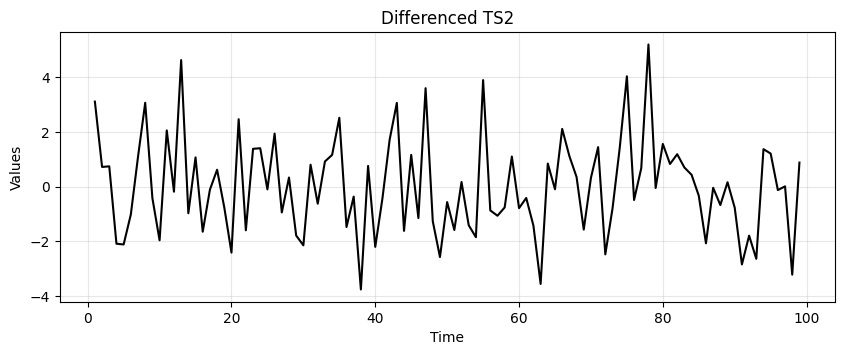

In [51]:
diff_ts2 = np.diff(detrended_ts2)
run_sequence_plot(time[1:], diff_ts2, title="Differenced TS2");

adf_log, diff_ts2, _, _, _, _ = adfuller(diff_ts2)
print(f"p-value: {diff_ts2:.3f}")

The p value now is low enaugh. To recap:

- TS2 had both a costant trend and a non constant autocorrelation.
- After removing the trend and applying differentiation, TS2 becoma stationary.